In [1]:
import matplotlib.pyplot as plt
import statistics

%matplotlib inline

In [2]:
_tmp = __import__("dse-user_vars_ren")
globals().update(vars(_tmp))

In [3]:
class Strategy(object):
    def __init__(self):
        pass
    
    # default strategy is random
    def choose(self, events, choices, possible_children={}):
        acts = {k: random.choice(choices[k]) for k in choices.keys()}
        child_acts = {}
        for period, act in acts.items():
            for event in events[act]:
                if event in possible_children.keys():
                    selected = random.choice(possible_children[event])
                    if selected is not None:
                        child_acts[event] = selected.name
        return acts, child_acts

    # accessory method that will be used by other strategies
    def get_deltas(self, event_list):
        # events in event list are string names
        global stats
        global store

        deltas = {}
        
        for event in event_list:
            # I wish we could do dynamic programming here but these values may change depending on game state...
            deltas[event] = {}

            # first dump stuff from store into locals
            for var in stats.keys():
                locals()[var] = getattr(store, var)

            # now run changes from event
            e = event_name_to_obj(event)
            if e is not None:
                for change in e.changes:
                    exec(change)

            # now find the changes and save them
            for var in stats.keys():
                #if locals()[var] != getattr(store, var):
                deltas[event][var] = locals()[var] - getattr(store, var)

        return deltas

class MinMaxer(Strategy):
    def __init__(self, priorities):
        self.priorities = priorities

    def best_delta(self, event_lists, best_children={}):
        # event_lists is dict of format
        # key: action
        # value: list of events
        
        deltas = {}
        for action, event_list in event_lists.items():
            these_deltas = self.get_deltas(event_list)
            deltas[action] = {}
            for event, stats in these_deltas.items():
                for stat, change in stats.items():
                    if stat in deltas[action]:
                        deltas[action][stat] += change
                    else:
                        deltas[action][stat] = change
                if event in best_children:
                    child_event = best_children[event]
                    if child_event is not None:
                        delta_delta = self.get_deltas([child_event])
                        for stat in delta_delta[child_event].keys():
                            deltas[action][stat] += delta_delta[child_event][stat]
        
        solved = False
        prio_ind = 0
        elg_actions = list(event_lists.keys())
        
        while not solved:
            stat = self.priorities[prio_ind]
            max_val = -999
            next_elg = []

            # find everything with the best value for our current stat
            for action in elg_actions:
                delta = deltas[action]
                if delta[stat] > max_val:
                    max_val = delta[stat]
                    next_elg = [action]
                elif delta[stat] == max_val:
                    next_elg.append(action)

            # if only one item has the maximum value for the thing we're looking for
            # that's the best one
            if len(elg_actions) == 1:
                solved = True
                event = next_elg[0]
            else:
                # otherwise, defer to next stat in priorities
                prio_ind += 1
                elg_actions = next_elg

                # pick a random eligible event if all are equally qualified
                if prio_ind == len(self.priorities):
                    solved = True
                    event = random.choice(elg_actions)

        return event
    
    def choose(self, events, choices, possible_children={}):
        child_acts = {}

        # first find best children deltas
        for period, actions in choices.items():
            for action in actions:
                for event in events[action]:
                    if event in possible_children.keys():
                        refactored = {}
                        for child in possible_children[event]:
                            if child is not None:
                                refactored[child.name] = [child.name]
                        child_acts[event] = self.best_delta(refactored) # list of possible child events

        acts = {}

        for period, actions in choices.items():
            refactor = {}
            for action in actions:
                refactor[action] = events[action]
                
            acts[period] = self.best_delta(refactor, child_acts)
        
        return acts, child_acts

In [4]:
def simulate_game(tracked_stats, strat=None, debug=False):
    # playing loose and fast with global scope here because that's the expected behavior in renpy and this isn't oop
    result = False
    day = 0
    tracking = {k:[] for k in tracked_stats}

    if strat is None:
        strat = Strategy()

    reset() # resets stat store variables
    e = EventDispatchSimulator()
    
    while not result:
        day += 1
        events = e.start_day() 
        # dict with 
        # key: act, value: list of events

        choices, possible_children = e.get_choices()
        # choides is dict with
        # key: period, value: list of acts

        # possible_children is dict with
        # key: event, value: list of possible sub-events

        acts, child_acts = strat.choose(events, choices, possible_children)

        if debug:
            print(f"day {day}, { {k: events[v] for k,v in acts.items()} }, children {child_acts}")
        
        result = e.run_day(acts, child_acts)
        for stat in tracked_stats:
            tracking[stat].append(getattr(store, stat))

    return result, tracking, e.events_executed

def montecarlo(tracked_stats, n=100, strat=None, debug=False):
    endings = {}
    stats = {}
    events_seen = {}
    events_executed = {}
    for i in range(n):
        result, tracking, events = simulate_game(tracked_stats, strat=strat, debug=debug)
        runtime = len(tracking[tracked_stats[0]]) # number of turns to reach ending
        
        if result in endings.keys():
            endings[result].append(runtime)
        else:
            endings[result] = [runtime]
        for stat in tracked_stats:
            if stat not in stats.keys():
                stats[stat] = []
            
            for i in range(runtime):
                if i >= len(stats[stat]):
                    stats[stat].append([tracking[stat][i]])
                else:
                    #print(stats[stat])
                    #print(tracking[stat][i])
                    stats[stat][i].append(tracking[stat][i])
                    
        for event, tally in events.items():
            if event in events_seen:
                events_seen[event] += 1
                events_executed[event] += tally
            else:
                events_seen[event] = 1
                events_executed[event] = tally
    return endings, stats, events_seen, events_executed

In [43]:
n = 100
endings, result_stats, events_seen, events_executed = montecarlo(["intelligence","strength","relaxation"], n)

In [46]:
for end, turns in endings.items():
    print(f"{end}:\n\t{len(turns)} times ({ len(turns)/n * 100:.2f}%)\n\t{statistics.mean(turns):.2f} days average")
    if len(turns) > 1:
        print(f"\t{statistics.stdev(turns):.2f} days stdev\n\t{min(turns)}-{max(turns)} turn range")
    else:
        print(f"\t1 turn")

relaxed_ending:
	89 times (89.00%)
	18.49 days average
	6.80 days stdev
	6-35 turn range
gg_confess:
	10 times (10.00%)
	29.70 days average
	6.22 days stdev
	20-36 turn range
sg_confess:
	1 times (1.00%)
	40.00 days average
	1 turn


In [47]:
print(f"locked in {events_seen['_introduction_focus']} of {n} times")

locked in 46 of 100 times


In [48]:
events_seen

{'introduction': 100,
 'hang': 100,
 'exercise': 83,
 'class': 98,
 'study': 81,
 'cut2': 99,
 'chat': 99,
 'gg_studying': 96,
 'catchme': 92,
 'cut1': 99,
 'play': 100,
 'cantcatchme': 79,
 'borrow_pen': 64,
 'gg_smiling': 56,
 'relaxed_ending': 89,
 'bookslide': 19,
 '_introduction_focus': 46,
 'caughtme': 19,
 'apart': 4,
 'together': 15,
 'cookies': 12,
 'gg_confess': 10,
 'pothole': 1,
 'fly': 1,
 'dontsee': 1,
 'sg_confess': 1}

In [49]:
events_executed

{'introduction': 100,
 'hang': 889,
 'exercise': 135,
 'class': 894,
 'study': 127,
 'cut2': 498,
 'chat': 610,
 'gg_studying': 463,
 'catchme': 92,
 'cut1': 479,
 'play': 626,
 'cantcatchme': 344,
 'borrow_pen': 64,
 'gg_smiling': 309,
 'relaxed_ending': 89,
 'bookslide': 19,
 '_introduction_focus': 46,
 'caughtme': 19,
 'apart': 9,
 'together': 46,
 'cookies': 12,
 'gg_confess': 10,
 'pothole': 1,
 'fly': 1,
 'dontsee': 1,
 'sg_confess': 1}

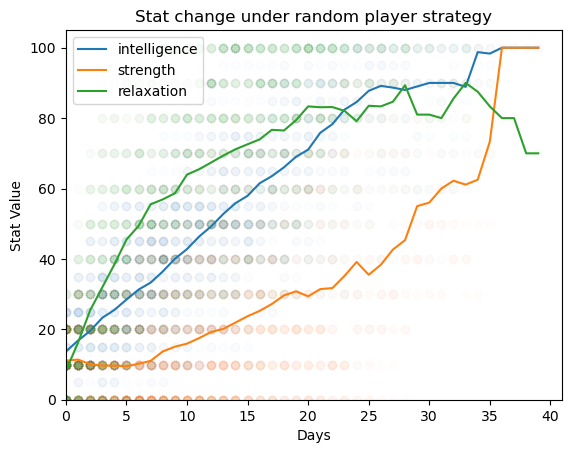

In [50]:
lines = {}
for stat, values in tesult_stats.items():
    vals = [statistics.mean(x) for x in values]
    sc_y = [item for sublist in values for item in sublist]
    sc_x = [item for sublist in  [[i] * len(values[i]) for i in range(len(values))] for item in sublist]
    plt.plot(
        list(range(len(vals))),
        vals,
        label = stat
    )
    plt.scatter(sc_x, sc_y, alpha=0.01)
plt.title("Stat change under random player strategy")
plt.legend(loc="upper left")
plt.xlabel("Days")
plt.ylabel("Stat Value")

plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

plt.show()

In [6]:
goodplayer = MinMaxer(["strength", "intelligence"])
endings, result_stats, events_seen, events_executed = montecarlo(["intelligence","strength","relaxation"], n=n, strat=goodplayer)

In [8]:
n=100

In [9]:
for end, turns in endings.items():
    print(f"{end}:\n\t{len(turns)} times ({ len(turns)/n * 100:.2f}%)\n\t{statistics.mean(turns):.2f} days average")
    if len(turns) > 1:
        print(f"\t{statistics.stdev(turns):.2f} days stdev\n\t{min(turns)}-{max(turns)} turn range")
    else:
        print(f"\t1 turn")

gg_confess:
	26 times (26.00%)
	17.58 days average
	2.06 days stdev
	15-22 turn range
both_confess:
	42 times (42.00%)
	19.29 days average
	2.03 days stdev
	16-24 turn range
sg_confess:
	32 times (32.00%)
	16.91 days average
	1.47 days stdev
	15-20 turn range


In [10]:
print(f"locked in {events_seen['_introduction_focus']} of {n} times")

locked in 100 of 100 times


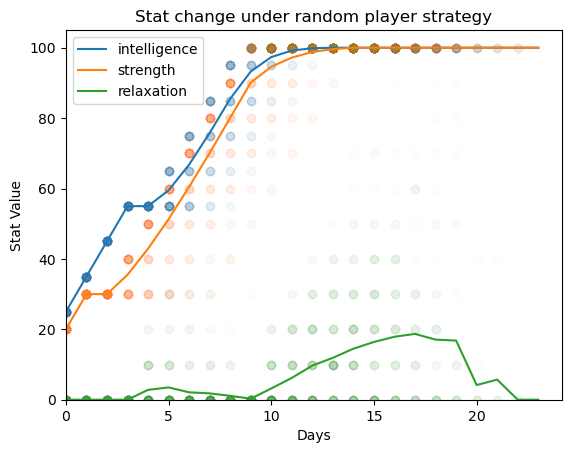

In [11]:
lines = {}
for stat, values in result_stats.items():
    vals = [statistics.mean(x) for x in values]
    sc_y = [item for sublist in values for item in sublist]
    sc_x = [item for sublist in  [[i] * len(values[i]) for i in range(len(values))] for item in sublist]
    plt.plot(
        list(range(len(vals))),
        vals,
        label = stat
    )
    plt.scatter(sc_x, sc_y, alpha=0.01)
plt.title("Stat change under smart player strategy")
plt.legend(loc="upper left")
plt.xlabel("Days")
plt.ylabel("Stat Value")

plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

plt.show()